# Clonal Selection in Normal Tissues

## Introduction
In this practical session, we will explore the signals of **positive selection** in somatic mutations of the normal bladder urothelium.

Clonal selection is the process by which certain mutations provide a fitness advantage to cells, allowing them to outcompete their neighbors and expand within a tissue. This is a fundamental process in both cancer development and the aging of normal tissues (clonal hematopoiesis, etc.).

We will proceed with the analysis in three main steps:

1.  **Mutation Landscape**: Analyzing the frequency and distribution of mutation types (synonymous, missense, truncating).

2.  **Signals of selection**: Using state-of-the-art tools to detect clonal selection:
    *   **$\omega$ (dN/dS)**: Do we observe more mutations than expected? (https://github.com/bbglab/omega)
    *   **OncodriveFML**: Are the mutations we are observing biased towards high functional impact? (https://github.com/bbglab/oncodrivefml)
    *   **Oncodrive3D**: Are the mutations detected clustered in the 3D space? (https://github.com/bbglab/oncodrive3d)

3.  **Epidemiological Correlation**: Investigating how these selection signals vary with patient metadata like **Age** and **Sex**.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import generate_all_side_figures, get_all_data, get_counts_per_position_n_consequence, plot_count_track, plot_stacked_bar_track_binned, metrics_colors_dictionary


# Set display options
pd.set_option('display.max_columns', None)

In [2]:
data_path = "../../course_data_2026/Clonal_selection_data"
input_data_path = f"{data_path}/input"
output_data_path = f"{data_path}/output"

## 1. Select a subset of genes

In small groups, pick some genes from the available list. You may see more genes in the input files provided to the notebook, but these are the ones with complete information

In [3]:
possible_genes = ['CREBBP', 'KMT2D', 'RBM10', 'TP53', 'PIK3CA', 'ARID1A',
                  'FGFR3', 
                  'EP300', 'KDM6A', 'FOXQ1',
                  'CDKN1A', 'NOTCH2', 'STAG2',
                  'RB1',
                  ]

### Download Data
*Instructions: Download the folder corresponding to your chosen gene. For this notebook, we assume the files are present in the current working directory.*

Define your chosen gene and sample name below. Based on the file structure, the "sample" name for the combined analysis is likely `all_samples`.

In [4]:
# Define your gene and sample
GENE_LIST = ["KMT2D", "CREBBP", "RBM10"]  # Change this to your chosen gene (e.g., CREBBP, EP300, RBM10, etc.)
SAMPLE_NAME = "all_samples"

## 2. Analyzing the Mutation Landscape

Before jumping into complex selection metrics, it is crucial to understand the "raw" data. Mutations are generally classified into:
*   **Synonymous**: Usually neutral (do not change the protein).
*   **Missense**: Change one amino acid; can be neutral, damaging, or activating.
*   **Truncating (Nonsense/Frameshift)**: Often lead to loss of function (LOF).

### Activity 1: Visual Inspection
Look at the generated plots for your selected genes and consider the following:
1.  **Hotspots**: Are mutations clustered in specific regions of the protein, or are they spread out?
2.  **Mutation Types**: Does the gene have more missense or truncating mutations? What does this suggest about its role (oncogene vs. tumor suppressor)?
3.  **Frequency**: Visually, compare the number of synonymous mutations (the "background") to the non-synonymous ones.


Processing gene: KMT2D
             Consequence  Count
0               missense   4093
1               nonsense   4678
2  splice_region_variant     60
3             synonymous    944


/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


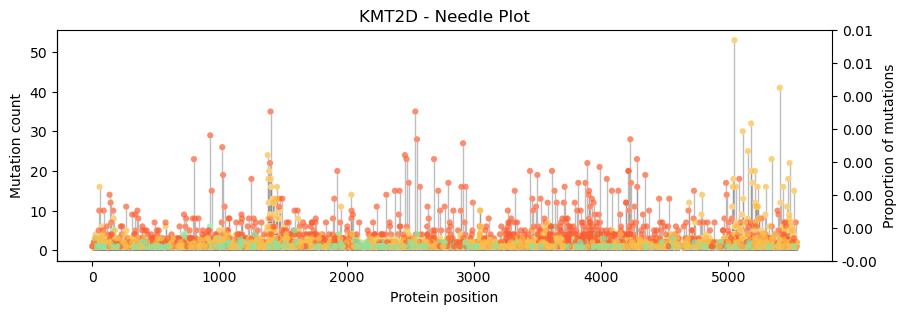

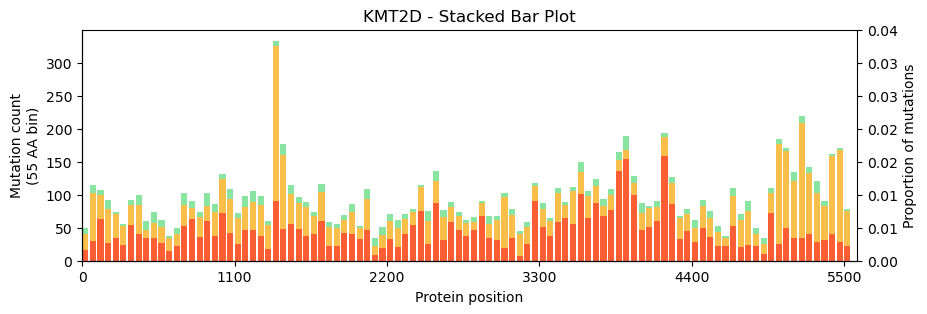

Processing gene: CREBBP
             Consequence  Count
0               missense   1630
1               nonsense    224
2  splice_region_variant      9
3             synonymous    283


/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


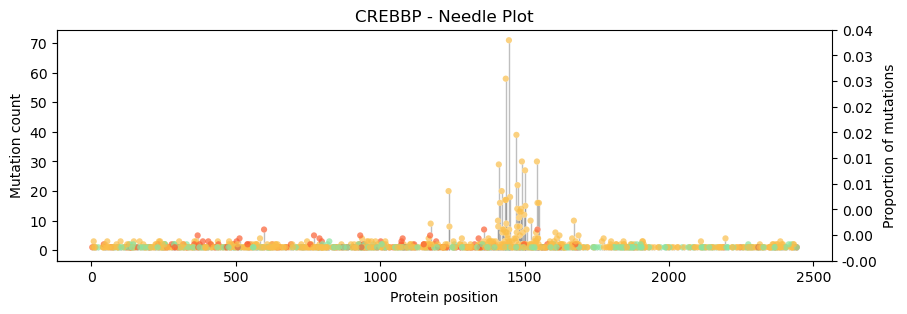

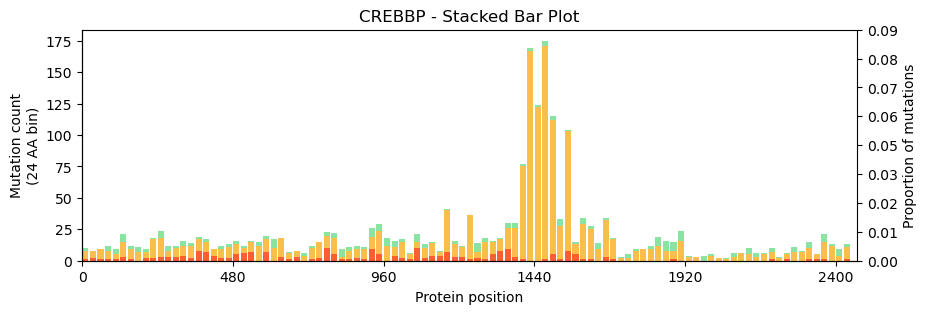

Processing gene: RBM10
             Consequence  Count
0               missense    934
1               nonsense   1336
2  splice_region_variant     47
3             synonymous    142


/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


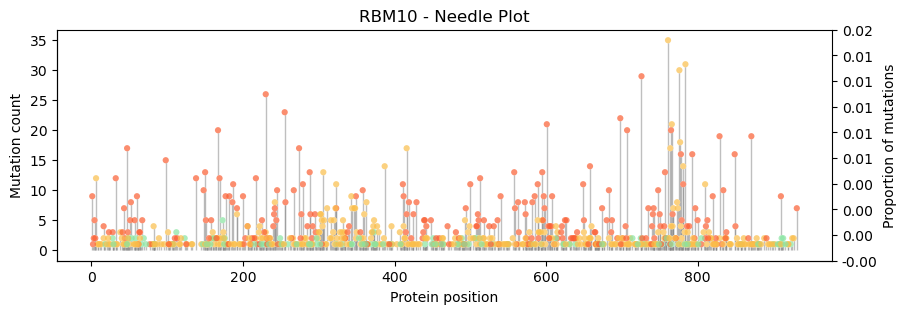

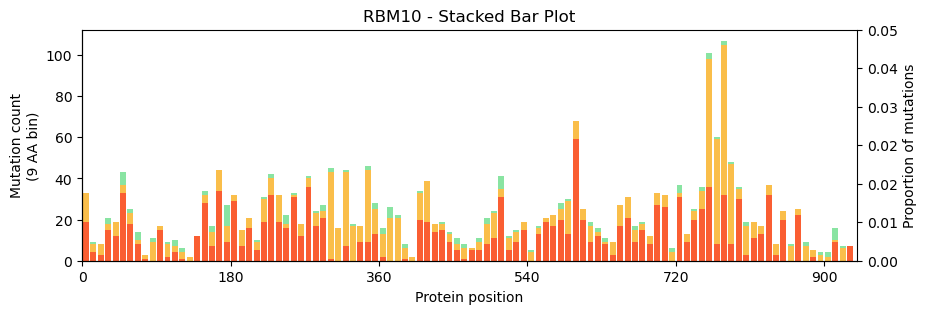

In [5]:
mutations_file = f"{input_data_path}/{SAMPLE_NAME}.somatic.mutations.tsv"
outdir = output_data_path

if os.path.exists(mutations_file):
    
    # Get counts
    counts_per_position = get_counts_per_position_n_consequence(mutations_file)

    for GENE_NAME in GENE_LIST:
        print(f"Processing gene: {GENE_NAME}")
        
        # Filter for selected gene
        gene_counts = counts_per_position[counts_per_position["Gene"] == GENE_NAME]
        print(gene_counts.groupby(by=["Consequence"])["Count"].sum().reset_index())

        if not gene_counts.empty:
            # 1. Needle Plot
            mut_count_df = gene_counts.groupby(by=["Pos", "Consequence"])["Count"].sum().reset_index()
            fig, ax = plt.subplots(1, 1, figsize=(10, 3))
            plot_count_track(
                mut_count_df,
                gene_len=mut_count_df["Pos"].max(), 
                axes=[ax], ax=0,
                colors_dict=metrics_colors_dictionary, indel=False, alpha=0.7
            )
            ax.set_title(f"{GENE_NAME} - Needle Plot")
            plt.show()

            # 2. Stacked Bar Plot
            fig, ax = plt.subplots(1, 1, figsize=(10, 3))
            plot_stacked_bar_track_binned(
                count_df=mut_count_df,
                gene_len=mut_count_df["Pos"].max(),
                axes=[ax], ax=0,
                colors_dict=metrics_colors_dictionary,
                alpha=1,
                indel=False
            )
            ax.set_title(f"{GENE_NAME} - Stacked Bar Plot")
            plt.show()
        else:
            print(f"No mutations found for gene {GENE_NAME}")
else:
    print(f"File {mutations_file} not found. Please ensure you have downloaded the data.")

## 3. Quantifying Selection Pressure

We will now apply three complementary methods to detect positive selection. Each looks at a different aspect of "selection":

#### A. $\omega$ (dN/dS)
This is the "gold standard" in molecular evolution. It calculates the ratio of observed non-synonymous mutations to expected ones (based on synonymous rates).
*   **$\omega = 1$**: Neutral evolution.
*   **$\omega > 1$**: Positive (diversifying) selection.
*   **$\omega < 1$**: Negative (purifying) selection.

#### B. OncodriveFML (Functional Impact)
Detects genes where mutations have a higher **functional impact score** (e.g., CADD) than expected by chance. This helps identify high-impact variants even if they aren't clustered.

#### C. Oncodrive3D (Structural Clustering)
Identifies genes where mutations cluster together in **3D space** on the protein surface, even if they are far apart in the 1D sequence. This is a strong signal for activating mutations in oncogenes.

### Activity 2: Metric Comparison
Run the cells below to view the numerical tables and summary tracks. Then, discuss in your group:
1.  **Consistency**: Do all three metrics agree on your selected genes?
2.  **Surprises**: Are there genes with high $\omega$ but no 3D clustering? Why might that be? (Hint: Think about Tumor Suppressors).
3.  **Drivers**: Based on these tracks, which gene shows the clearest evidence of being a driver in this cohort?


In [6]:
omega_data = pd.read_table(f"{input_data_path}/all_omega_values.tsv")
omega_data[(omega_data["sample"] == 'all_samples')
           & (omega_data["gene"].isin(GENE_LIST))]

,gene,sample,impact,mutations,dnds,pvalue,lower,upper
244,CREBBP,all_samples,missense,1605,2.758594,0.0,2.529768,3.008838
245,CREBBP,all_samples,truncating,398,5.171875,0.0,4.449767,6.003784
250,KMT2D,all_samples,missense,4039,1.882227,0.0,1.745101,2.031152
251,KMT2D,all_samples,truncating,5702,20.448242,0.0,18.675614,22.409912
267,RBM10,all_samples,missense,925,3.281250,0.0,2.969778,3.623657
268,RBM10,all_samples,truncating,1940,37.742188,0.0,33.989465,41.954834


In [7]:
oncodrivefml_data = pd.read_table(f"{input_data_path}/all_samples-oncodrivefml.tsv.gz")
oncodrivefml_data[oncodrivefml_data["SYMBOL"].isin(GENE_LIST)]

,GENE_ID,MUTS,MUTS_RECURRENCE,SAMPLES,AVG_SCORE_OBS,P_VALUE,Q_VALUE,P_VALUE_NEG,Q_VALUE_NEG,SNP,MNP,INDELS,POPULATION_MEAN,POPULATION_STD,STD_OF_MEANS,Z-SCORE,SYMBOL
0,KMT2D,11331,4619,79,28.635332,0.000001,0.000001,1.0,1.0,11107,224,0,17.884891,9.754649,0.091638,117.31371,KMT2D
2,RBM10,3372,980,79,30.234241,0.000001,0.000001,1.0,1.0,3318,54,0,19.507152,10.070766,0.173428,61.85334,RBM10
5,CREBBP,2395,1327,79,24.459155,0.000001,0.000001,1.0,1.0,2377,18,0,20.341744,10.409844,0.212712,19.35676,CREBBP


Generating side figures...
KMT2D	

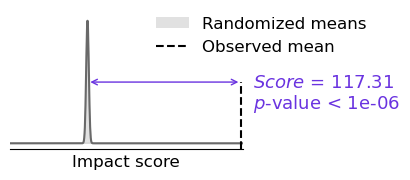

ofml done	         type  number_obs     expected      omega  pvalue
0  truncating      5702.0   278.850375  20.448242     0.0
1  synonymous       944.0          NaN        NaN     NaN
2    missense      4039.0  2145.862820   1.882227     0.0


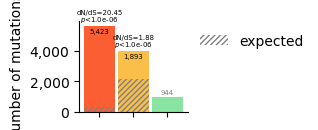

omega done	CREBBP	

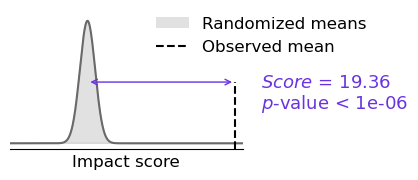

ofml done	         type  number_obs    expected     omega  pvalue
0  truncating       398.0   76.954683  5.171875     0.0
1  synonymous       283.0         NaN       NaN     NaN
2    missense      1605.0  581.818182  2.758594     0.0


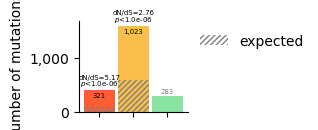

omega done	RBM10	

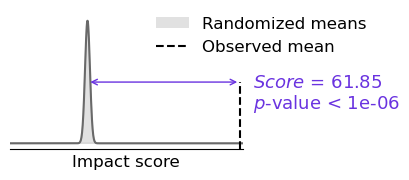

ofml done	         type  number_obs    expected      omega  pvalue
0  truncating      1940.0   51.401366  37.742188     0.0
1  synonymous       142.0         NaN        NaN     NaN
2    missense       925.0  281.904762   3.281250     0.0


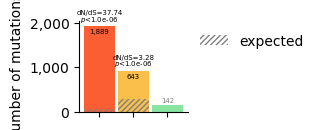

omega done	
Generating summary tracks...
Loaded OncodriveFML data from ../../course_data_2026/Clonal_selection_data/input/all_samples-oncodrivefml.tsv.gz
Truncating
 ['KDM6A', 'RBM10', 'KMT2D', 'ARID1A', 'ALL_GENES', 'STAG2', 'CDKN1A', 'EP300', 'CREBBP', 'NOTCH2', 'TP53', 'FOXQ1', 'KMT2C', 'RB1', 'PIK3CA', 'FGFR3']
Missense
 ['TERTpromoter', 'TP53', 'KDM6A', 'RBM10', 'PIK3CA', 'EP300', 'CREBBP', 'NOTCH2', 'FOXQ1', 'CDKN1A', 'ALL_GENES', 'KMT2D', 'STAG2', 'RB1', 'ARID1A', 'KMT2C', 'FGFR3']
Global
 ['KDM6A', 'RBM10', 'KMT2D', 'CDKN1A', 'ARID1A', 'STAG2', 'EP300', 'TP53', 'CREBBP', 'NOTCH2', 'FOXQ1', 'KMT2C', 'RB1', 'PIK3CA', 'FGFR3']
all_positively_selected ['ALL_GENES', 'ARID1A', 'CDKN1A', 'CREBBP', 'EP300', 'FOXQ1', 'KDM6A', 'KMT2C', 'KMT2D', 'NOTCH2', 'PIK3CA', 'RB1', 'RBM10', 'STAG2', 'TERTpromoter', 'TP53']
positively_selected_both ['ALL_GENES', 'ARID1A', 'CDKN1A', 'CREBBP', 'EP300', 'FOXQ1', 'KDM6A', 'KMT2C', 'KMT2D', 'NOTCH2', 'RB1', 'RBM10', 'STAG2', 'TP53']
positively_selected_t

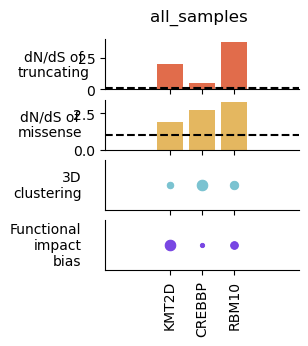

In [8]:
# Generate "Side Figures" (Individual metric details)
# Note: This function generates plots for available metrics for the sample
print("Generating side figures...")
generate_all_side_figures(SAMPLE_NAME, outdir=outdir, gene_list=GENE_LIST, data_path = input_data_path)

# Generate Summary Plot (All tracks combined)
print("\nGenerating summary tracks...")
get_all_data(SAMPLE_NAME, outdir=outdir, tracks=("omega_trunc", "omega_mis", "oncodrive3d", "oncodrivefml"), gene_order=GENE_LIST, data_path = input_data_path)

### Summary Tracks Visualization
The function `utils.get_all_data` generates a multi-track plot. 
*   **Top tracks**: Barplots for $\omega$ (dN/dS). Error bars indicate confidence intervals. If a bar is above 1 and the p-value is significant (filled color), the gene is positively selected.
*   **Bottom tracks**: Bubble plots for OncodriveFML and Oncodrive3D. The size of the bubble relates to the experimental score, and the color indicates significance.


## 4. Selection and Demographics: Sex-Based Differences

Factors like sex can influence mutation rates and the selective advantage of certain clones due to hormonal environments, lifestyle, or genetic differences (e.g., X-chromosome).

In this section, we sort the dN/dS values for each individual sample and plot them. This allows us to see if the entire distribution of selection is shifted between Males and Females.

### Activity 3: Sex-Based Analysis
1.  **Shift**: Look at the sigmoid curves. Is the 'M' curve consistently higher than the 'F' curve for any gene?
2.  **Hypothesis**: If you see a difference, do you think it is due to a higher mutation rate or a higher "benefit" of the mutation in that group?


--- Sex Comparison: Sigmoid Rank Distribution ---
Analyzing KMT2D...


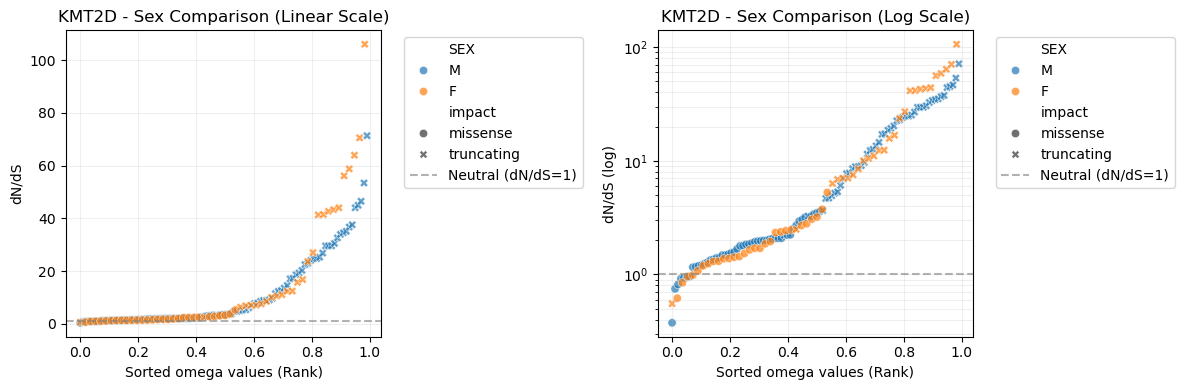

Analyzing CREBBP...


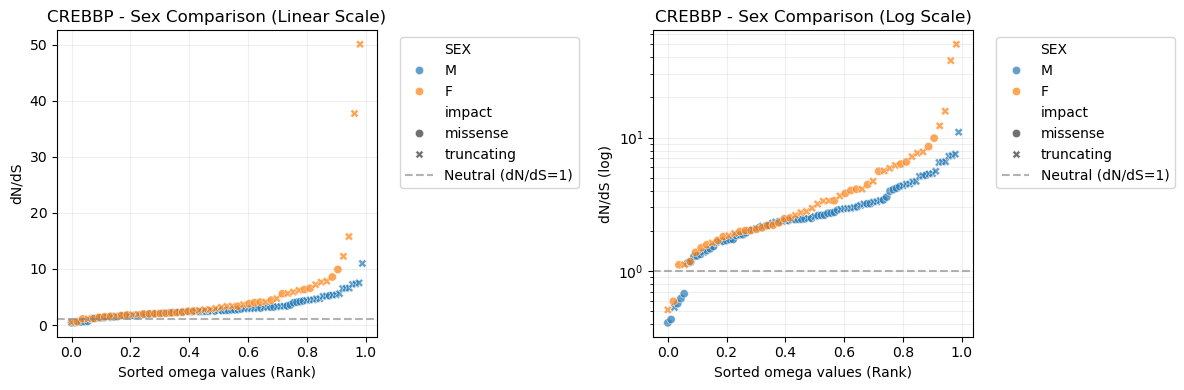

Analyzing RBM10...


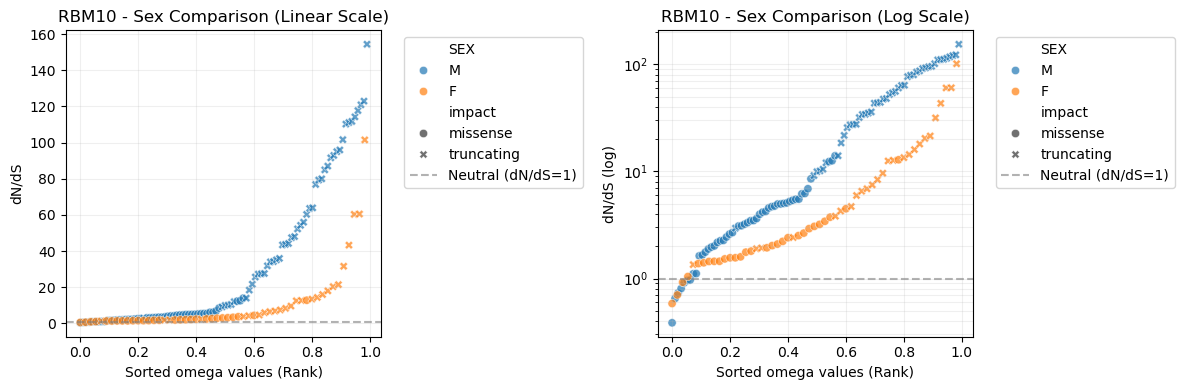

In [9]:
# Load Omega data with metadata
omega_file = f"{input_data_path}/all_omega_values.tsv"
metadata_file = f"{input_data_path}/metadata.tsv"

df_omega = pd.read_csv(omega_file, sep='\t')
df_metadata = pd.read_csv(metadata_file, sep='\t')

df_omega['gene_symbol'] = df_omega['gene']

# Merge datasets
df_merged = df_omega.merge(df_metadata, left_on='sample', right_on='SAMPLE_ID')

# Filter for 'missense' and 'truncating' impact
df_filtered = df_merged[df_merged['impact'].isin(['missense', 'truncating'])].copy()

# Cleaning: ensure dnds is numeric and positive for log scale
df_filtered['dnds'] = pd.to_numeric(df_filtered['dnds'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['dnds'])
df_filtered = df_filtered[df_filtered['dnds'] > 0]

print("--- Sex Comparison: Sigmoid Rank Distribution ---")
for GENE_NAME in GENE_LIST:
    print(f"Analyzing {GENE_NAME}...")
    gene_subset = df_filtered[df_filtered['gene_symbol'] == GENE_NAME].copy()
    
    if gene_subset.empty:
        print(f"No data for {GENE_NAME}")
        continue

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Prep Sigmoid Data
    groups = []
    for sex in ['M', 'F']:
        sex_subset = gene_subset[gene_subset['SEX'] == sex].sort_values('dnds').reset_index(drop=True)
        if not sex_subset.empty:
            sex_subset['rank'] = sex_subset.index / len(sex_subset)
            groups.append(sex_subset)
    
    if groups:
        df_sex_plot = pd.concat(groups)
        
        # 1. Normal Scale
        sns.scatterplot(data=df_sex_plot, x='rank', y='dnds', hue='SEX', style='impact', alpha=0.7, ax=ax1)
        ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.6, label='Neutral (dN/dS=1)')
        ax1.set_title(f"{GENE_NAME} - Sex Comparison (Linear Scale)")
        ax1.set_xlabel("Sorted omega values (Rank)")
        ax1.set_ylabel("dN/dS")
        ax1.grid(True, alpha=0.2)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 2. Log Scale
        sns.scatterplot(data=df_sex_plot, x='rank', y='dnds', hue='SEX', style='impact', alpha=0.7, ax=ax2)
        ax2.set_yscale('log')
        ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.6, label='Neutral (dN/dS=1)')
        ax2.set_title(f"{GENE_NAME} - Sex Comparison (Log Scale)")
        ax2.set_xlabel("Sorted omega values (Rank)")
        ax2.set_ylabel("dN/dS (log)")
        ax2.grid(True, which="both", alpha=0.2)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax1.set_title(f"No Sex data for {GENE_NAME}")

    plt.tight_layout()
    plt.show()


## 5. The Clock of Selection: Mutation Pressure vs. Age

As we age, our tissues accumulate mutations. However, does the **intensity** of selection change over time? In some tissues, we expect clones to start small and grow over decades, leading to higher detectable selection signals in older individuals.

### Activity 4: Age Correlation
1.  **Trends**: Do you see a clear "upward" slope in dN/dS values as Age increases? Explain possible reasons why yes or why no.


--- Age Comparison: dN/dS vs Age ---
Analyzing KMT2D...


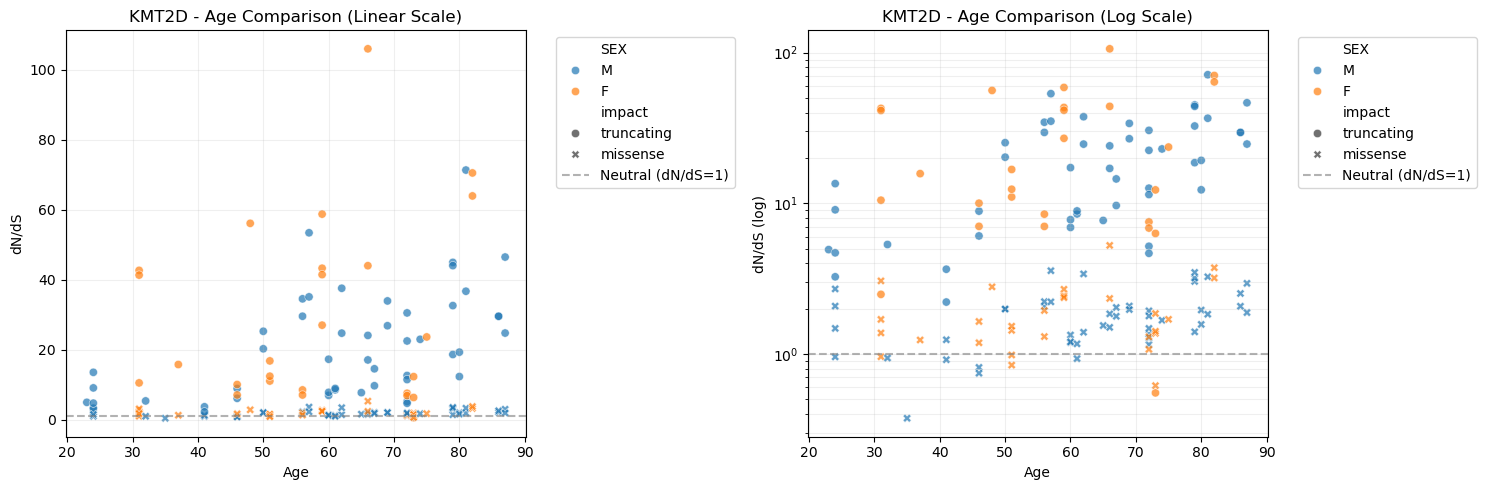

Analyzing CREBBP...


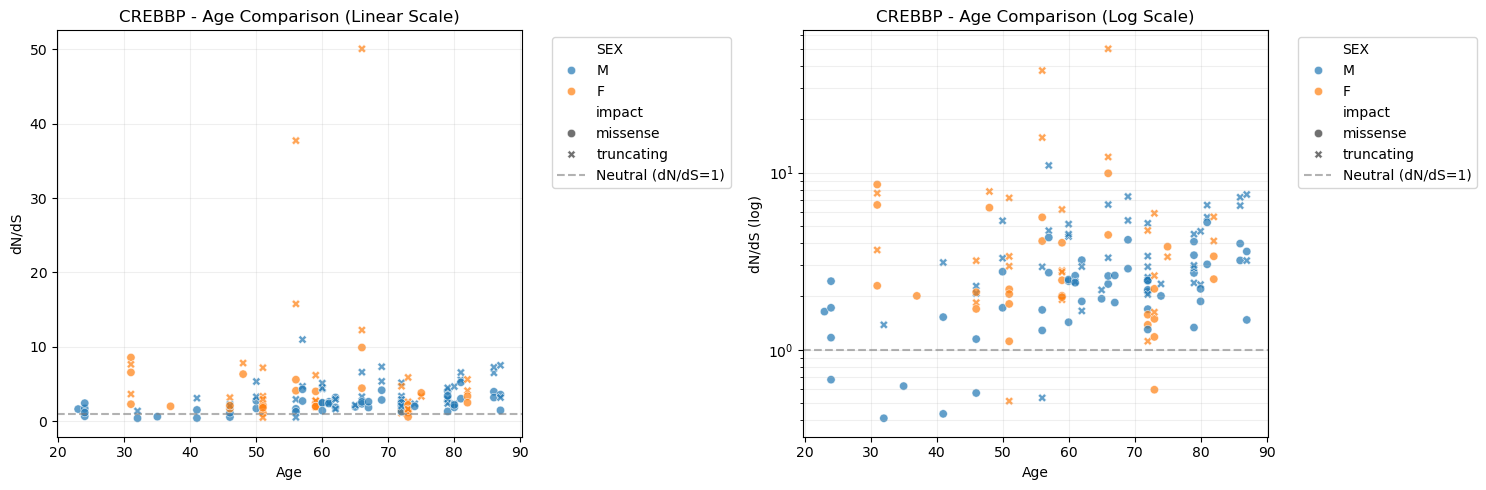

Analyzing RBM10...


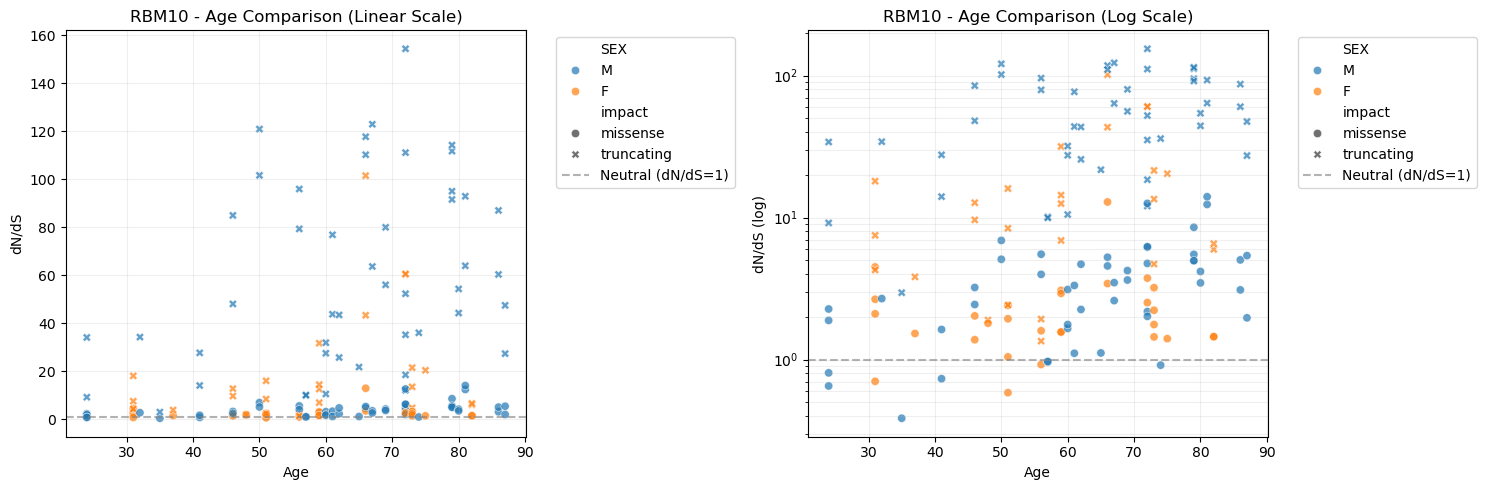

In [10]:
print("--- Age Comparison: dN/dS vs Age ---")
for GENE_NAME in GENE_LIST:
    print(f"Analyzing {GENE_NAME}...")
    gene_subset = df_filtered[df_filtered['gene_symbol'] == GENE_NAME].copy()
    
    if gene_subset.empty:
        print(f"No data for {GENE_NAME}")
        continue

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 1. Normal Scale
    sns.scatterplot(data=gene_subset.sort_values('AGE'), x='AGE', y='dnds', hue='SEX', style='impact', alpha=0.7, ax=ax1)
    ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.6, label='Neutral (dN/dS=1)')
    ax1.set_title(f"{GENE_NAME} - Age Comparison (Linear Scale)")
    ax1.set_xlabel("Age")
    ax1.set_ylabel("dN/dS")
    ax1.grid(True, alpha=0.2)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Log Scale
    sns.scatterplot(data=gene_subset.sort_values('AGE'), x='AGE', y='dnds', hue='SEX', style='impact', alpha=0.7, ax=ax2)
    ax2.set_yscale('log')
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.6, label='Neutral (dN/dS=1)')
    ax2.set_title(f"{GENE_NAME} - Age Comparison (Log Scale)")
    ax2.set_xlabel("Age")
    ax2.set_ylabel("dN/dS (log)")
    ax2.grid(True, which="both", alpha=0.2)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


### Mutation Density of non-protein affecting mutations

1. Does mutation density (non-protein affecting) show a stronger correlation with Age than dN/dS?

2. Are there significant differences in mutation rates between Males and Females for these genes?

3. Why do we look at non-protein affecting mutation density? (Hint: It serves as a neutral background rate).

--- Mutation Density Analysis (Non-Protein Affecting) ---
Analyzing KMT2D...


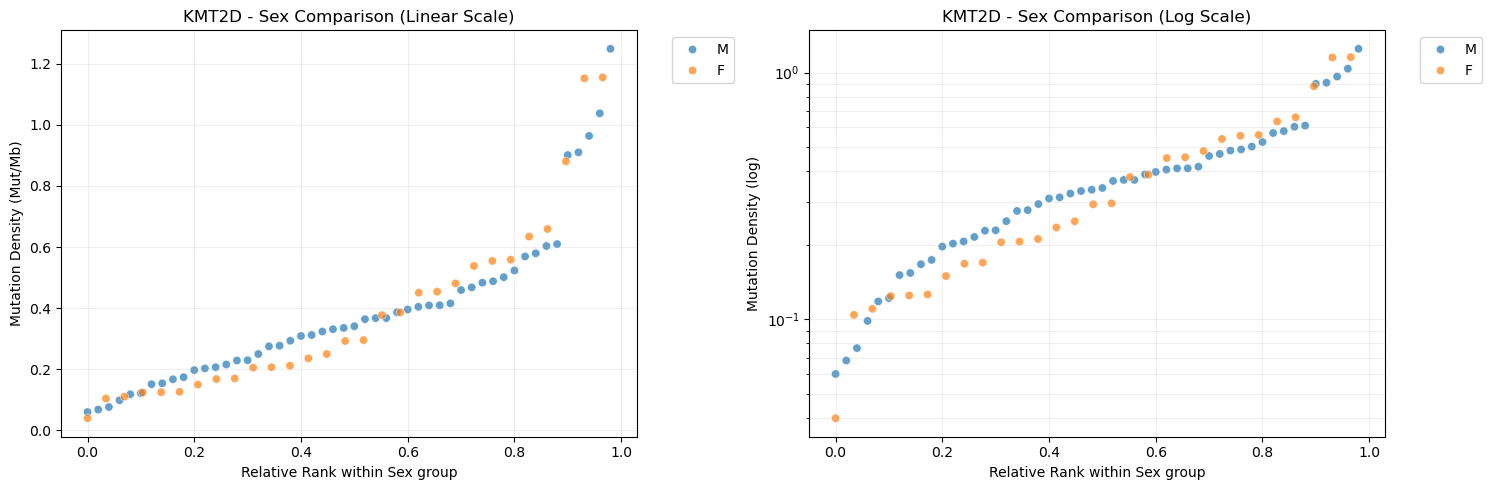

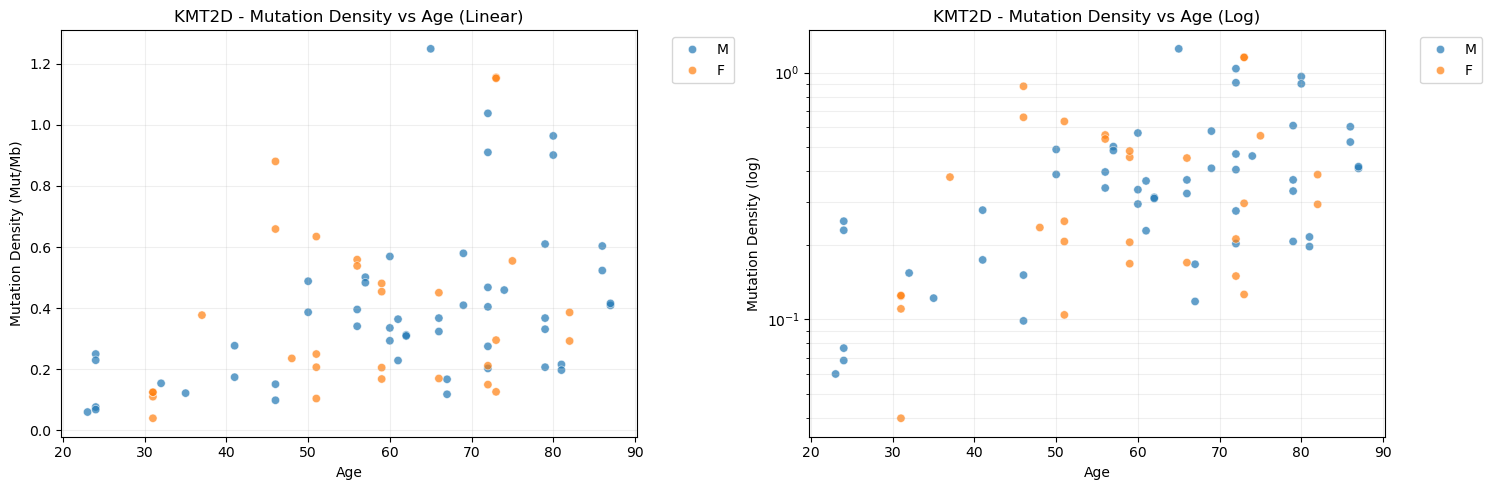

Analyzing CREBBP...


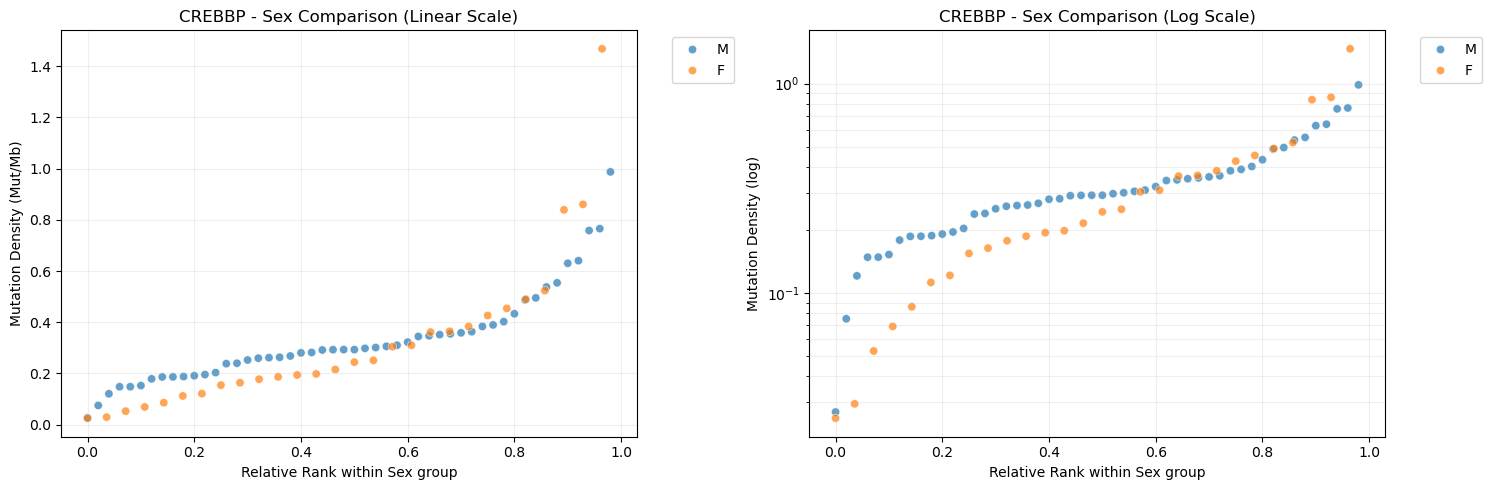

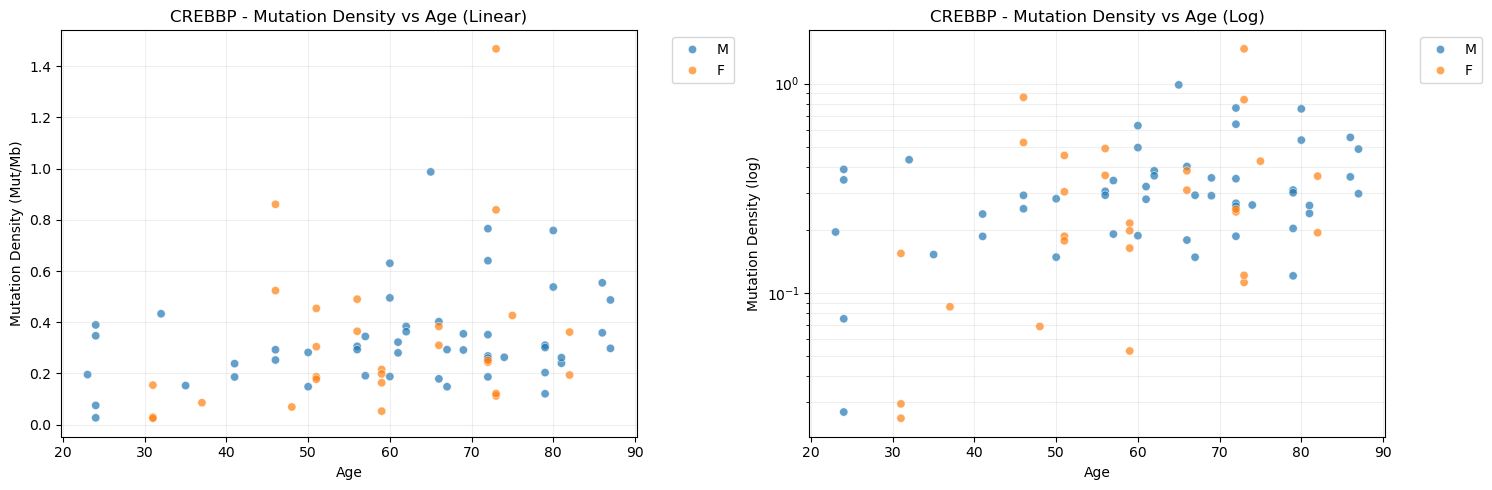

Analyzing RBM10...


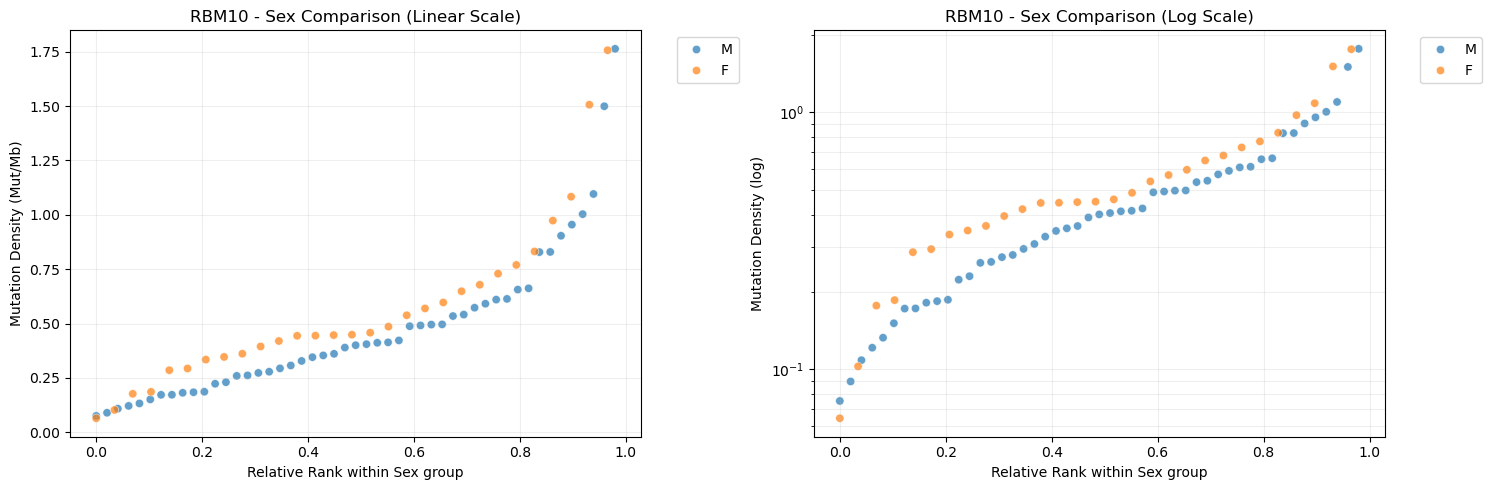

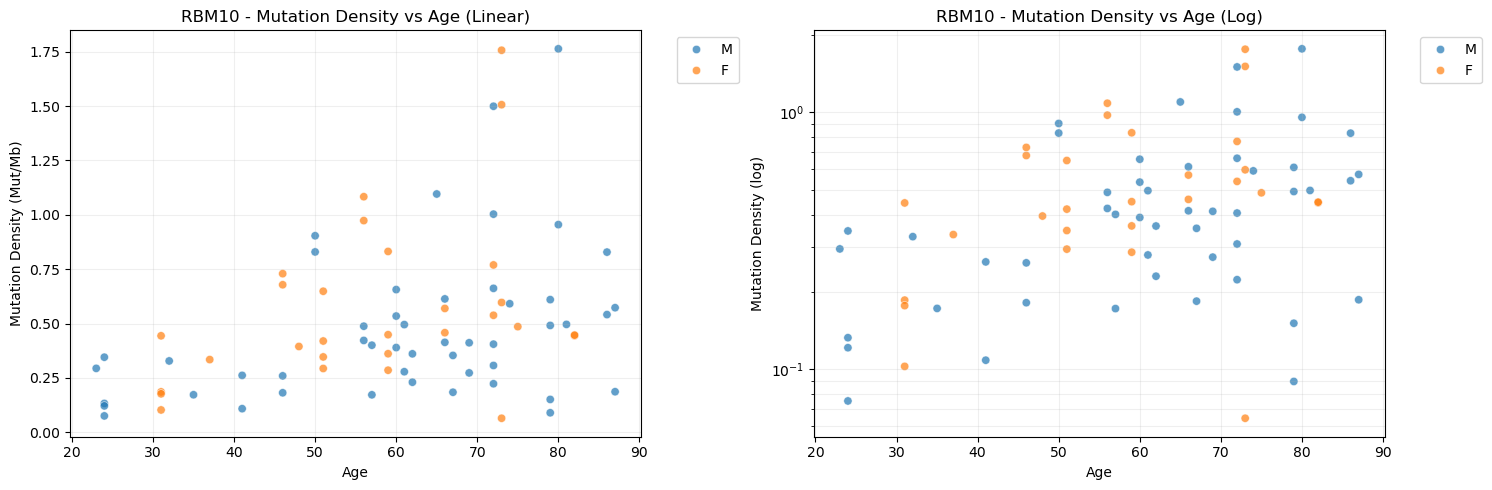

In [11]:
# Load Mutation Density data with metadata
mut_density_file = f"{input_data_path}/all_mutation_densities.tsv"
metadata_file = f"{input_data_path}/metadata.tsv"

df_mut_density = pd.read_csv(mut_density_file, sep='\t')
df_mut_density = df_mut_density[df_mut_density['REGIONS'] == 'non_protein_affecting'].copy()
df_metadata = pd.read_csv(metadata_file, sep='\t')

# Merge datasets on SAMPLE_ID
df_merged = df_mut_density.merge(df_metadata, on='SAMPLE_ID')

# Cleaning: ensure mutation density is numeric and positive for log scale
df_merged['MUTDENSITY_MB'] = pd.to_numeric(df_merged['MUTDENSITY_MB'], errors='coerce')
df_merged = df_merged.dropna(subset=['MUTDENSITY_MB'])
df_merged = df_merged[df_merged['MUTDENSITY_MB'] > 0]

print("--- Mutation Density Analysis (Non-Protein Affecting) ---")

for GENE_NAME in GENE_LIST:
    print(f"Analyzing {GENE_NAME}...")
    gene_subset = df_merged[df_merged['GENE'] == GENE_NAME].copy()
    
    if gene_subset.empty:
        print(f"No mutation density data found for {GENE_NAME}")
        continue

    # --- 1. Sex Comparison (Sigmoid/Rank Plot) ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    groups = []
    for sex in ['M', 'F']:
        sex_subset = gene_subset[gene_subset['SEX'] == sex].sort_values('MUTDENSITY_MB').reset_index(drop=True)
        if not sex_subset.empty:
            sex_subset['rank'] = sex_subset.index / len(sex_subset)
            groups.append(sex_subset)
    
    if groups:
        df_plot = pd.concat(groups)
        sns.scatterplot(data=df_plot, x='rank', y='MUTDENSITY_MB', hue='SEX', alpha=0.7, ax=ax1)
        ax1.set_title(f"{GENE_NAME} - Sex Comparison (Linear Scale)")
        ax1.set_xlabel("Relative Rank within Sex group")
        ax1.set_ylabel("Mutation Density (Mut/Mb)")
        ax1.grid(True, alpha=0.2)
        
        sns.scatterplot(data=df_plot, x='rank', y='MUTDENSITY_MB', hue='SEX', alpha=0.7, ax=ax2)
        ax2.set_yscale('log')
        ax2.set_title(f"{GENE_NAME} - Sex Comparison (Log Scale)")
        ax2.set_xlabel("Relative Rank within Sex group")
        ax2.set_ylabel("Mutation Density (log)")
        ax2.grid(True, which="both", alpha=0.2)
        
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # --- 2. Age Correlation ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.scatterplot(data=gene_subset, x='AGE', y='MUTDENSITY_MB', hue='SEX', alpha=0.7, ax=ax1)
    ax1.set_title(f"{GENE_NAME} - Mutation Density vs Age (Linear)")
    ax1.set_xlabel("Age")
    ax1.set_ylabel("Mutation Density (Mut/Mb)")
    ax1.grid(True, alpha=0.2)

    sns.scatterplot(data=gene_subset, x='AGE', y='MUTDENSITY_MB', hue='SEX', alpha=0.7, ax=ax2)
    ax2.set_yscale('log')
    ax2.set_title(f"{GENE_NAME} - Mutation Density vs Age (Log)")
    ax2.set_xlabel("Age")
    ax2.set_ylabel("Mutation Density (log)")
    ax2.grid(True, which="both", alpha=0.2)
    
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

## 6. Final Discussion & Wrap-up

Take a few minutes to synthesize your findings across the different sections.

### Final Questionnaire
1.  **Which gene from your list is the strongest driver?** What was your primary evidence (e.g., dN/dS p-value, 3D clustering, or high hotspot density)?
2.  **Divergence**: Did you find any gene where dN/dS was high ($\omega > 1$) but Oncodrive3D showed no clustering? What does this tell you about the mechanism of selection (e.g., LOF vs. activating)?
3.  **Applicability**:
    
    a. How could this information about selection pressure in normal tissues help in early cancer detection?

    b. Or how would you apply this or similar technology to contribute to the understanding of exposures and cancer risk?
